# Cassava Disease Detection 
## TFDS dataset -> https://www.tensorflow.org/datasets/catalog/cassava

"Cassava consists of leaf images for the cassava plant depicting healthy and four (4) disease conditions; Cassava Mosaic Disease (CMD), Cassava Bacterial Blight (CBB), Cassava Greem Mite (CGM) and Cassava Brown Streak Disease (CBSD). Dataset consists of a total of 9430 labelled images."

In [1]:
import tensorflow as tf
import numpy as np 
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt


In [2]:
# Load dataset. The dataset is already split into train val and test sets

(ds_train, ds_val, ds_test), ds_info = tfds.load('cassava', split = ['train', 'validation', 'test'], with_info = True,
                                               shuffle_files = True, as_supervised = True)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/3 [00:00<?, ? splits/s]

Generating train examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/cassava/0.1.0.incompleteFLQGKA/cassava-train.tfrecord*...:   0%|          …

Generating test examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/cassava/0.1.0.incompleteFLQGKA/cassava-test.tfrecord*...:   0%|          |…

Generating validation examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/cassava/0.1.0.incompleteFLQGKA/cassava-validation.tfrecord*...:   0%|     …

Dataset cassava downloaded and prepared to /root/tensorflow_datasets/cassava/0.1.0. Subsequent calls will reuse this data.


In [3]:
ds_info

tfds.core.DatasetInfo(
    name='cassava',
    full_name='cassava/0.1.0',
    description="""
    Cassava consists of leaf images for the cassava plant depicting healthy and
    four (4) disease conditions; Cassava Mosaic Disease (CMD), Cassava Bacterial
    Blight (CBB), Cassava Greem Mite (CGM) and Cassava Brown Streak Disease (CBSD).
    Dataset consists of a total of 9430 labelled images.
    The 9430 labelled images are split into a training set (5656), a test set(1885)
    and a validation set (1889). The number of images per class are unbalanced with
    the two disease classes CMD and CBSD having 72% of the images.
    """,
    homepage='https://www.kaggle.com/c/cassava-disease/overview',
    data_path='/root/tensorflow_datasets/cassava/0.1.0',
    file_format=tfrecord,
    download_size=1.26 GiB,
    dataset_size=1.26 GiB,
    features=FeaturesDict({
        'image': Image(shape=(None, None, 3), dtype=uint8),
        'image/filename': Text(shape=(), dtype=string),
        'lab

In [4]:
# print(f"Number of examples in training set: {len(list(ds_train))}")
# print(f"Number of examples in validation set: {len(list(ds_val))}")
# print(f"Number of examples in test set: {len(list(ds_test))}")

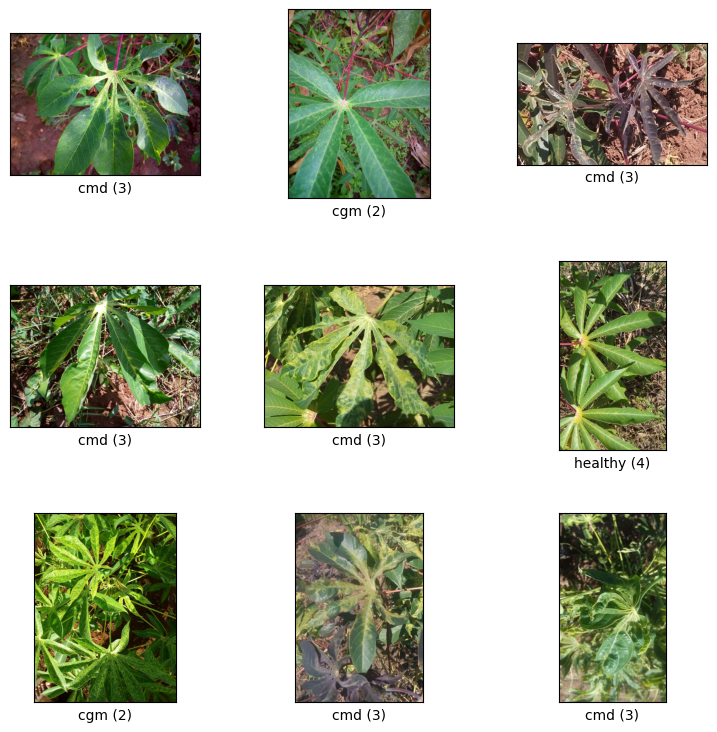

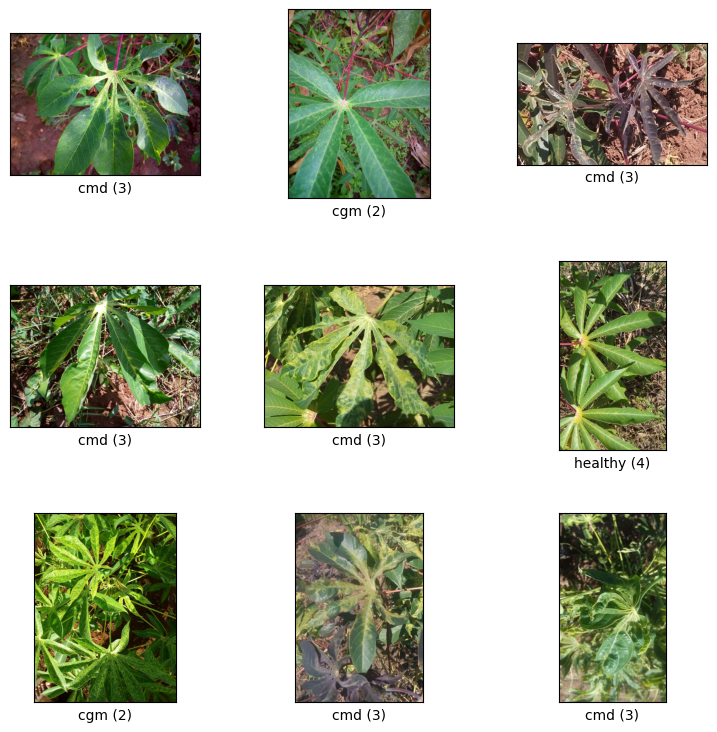

In [5]:
# Visualise and show examples of the datasets

train_ds_visualise = tfds.load('cassava', split='train', as_supervised = True)

# show examples
tfds.show_examples(train_ds_visualise, ds_info)

In [6]:
# A function to augment the dataset
def augment(image, label):
  image = tf.image.random_brightness(image, max_delta=0.2)
  image = tf.image.random_flip_left_right(image)
  image = tf.image.random_flip_up_down(image)

  return image, label

In [7]:
# Apply to the training set
ds_train = ds_train.map(augment)

In [8]:
# # normalise and resize all datasets
def preprocess_datasets(image, label):
  #image = tf.image.decode_jpeg(image, channels=3)
  image = tf.image.resize(image, (480, 480))   # recommended size for efficientNet V2 M and L
  image = tf.cast(image, tf.float32) / 255.0
  #image = tf.squeeze(image, axis=0)  # remove the extra dimension


  return image, label


In [9]:
# # map to each dataset

ds_train = ds_train.map(preprocess_datasets)
ds_val = ds_val.map(preprocess_datasets)
ds_test = ds_test.map(preprocess_datasets)

In [10]:
# Define batch size and prefetch

# batching combines consecutive elements of the dataset into batches
# This improves efficiency as GPUs are good at parallel computations

batch_size = 32
ds_train = ds_train.batch(batch_size=batch_size).prefetch(buffer_size=tf.data.AUTOTUNE)
ds_val = ds_val.batch(batch_size = batch_size).prefetch(buffer_size = tf.data.AUTOTUNE)
ds_test = ds_val.batch(batch_size=batch_size).prefetch(buffer_size = tf.data.AUTOTUNE)

# prefetching is when the model loads and preprocesses the next batch of data whilst 
# training on the current batch. Improves training speed because it doesnt need to wait for data to be loaded#
# tf.data.AUTOTUNE allows tf to find the optimum number of batches to preload

In [11]:
! pip install keras-tuner -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 172.2/172.2 KB 10.4 MB/s eta 0:00:00


In [12]:
from keras_tuner import HyperModel
#from keras.applications.efficientnet_v2 import efficientnet_v2L
import tensorflow_hub as hub

In [14]:
class cassavaDiseaseHyperModel(HyperModel):
  def __init__(self, input_shape, num_classes):
    self.num_classes = num_classes
    self.input_shape = input_shape

  def build(self, hp):

    # EfficientNet v2 M handle from the TF hub website
    hub_url = "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet1k_m/feature_vector/2"

    # Wrapping the model into a keras layer to be used pre classification layers
    ENet  = hub.KerasLayer(hub_url, trainable = False) # input_shape = (480, 480, 3))

    model = tf.keras.models.Sequential([
          ENet,
          #tf.keras.layers.GlobalAveragePooling2D(),
          tf.keras.layers.Dense(units = hp.Int('Units_1', min_value = 512, max_value = 1024, step = 32), activation = 'relu'),
          tf.keras.layers.Dropout(hp.Float('dropout_rate', min_value = 0.1, max_value = 0.5, step = 0.1 )),
          tf.keras.layers.Dense(units = hp.Int('Units_2', min_value = 128, max_value = 256, step = 32), activation = 'relu'),
          tf.keras.layers.Dense(units = self.num_classes, activation = 'softmax')
      ])
    
    model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = hp.Float('Learning_rate', min_value = 1e-4,
                                                                                max_value = 1e-2, sampling = 'LOG')),
                  loss = 'sparse_categorical_crossentropy',
                  metrics = ['accuracy'])
    
    return model
    


In [15]:
from keras_tuner.tuners import RandomSearch

input_shape = (480, 480, 3)
num_classes = (len(ds_info.features['label'].names))

In [16]:
hypermodel = cassavaDiseaseHyperModel(input_shape = input_shape, num_classes = num_classes)

17 (Units_1) * 5 (dropout_rate) * 5 (Units_2) * 10 (Learning_rate) = 4250 combinations

Ideally the number of trials would be >10% of the combinations. I'm not doing that to save computational resources

In [17]:
# 17 (Units_1) * 5 (dropout_rate) * 5 (Units_2) * 10 (Learning_rate) = 4250 combinations
tuner = RandomSearch(
    hypermodel,
    objective = 'val_accuracy',
    max_trials = 10,          ## Ideally would do 10% number of combinations. 
    executions_per_trial = 1,
    directory = 'my_dir',
    project_name = 'Cassava_Disease'
    )

In [18]:
tuner.search_space_summary()

Search space summary
Default search space size: 4
Units_1 (Int)
{'default': None, 'conditions': [], 'min_value': 512, 'max_value': 1024, 'step': 32, 'sampling': 'linear'}
dropout_rate (Float)
{'default': 0.1, 'conditions': [], 'min_value': 0.1, 'max_value': 0.5, 'step': 0.1, 'sampling': 'linear'}
Units_2 (Int)
{'default': None, 'conditions': [], 'min_value': 128, 'max_value': 256, 'step': 32, 'sampling': 'linear'}
Learning_rate (Float)
{'default': 0.0001, 'conditions': [], 'min_value': 0.0001, 'max_value': 0.01, 'step': None, 'sampling': 'log'}


In [20]:
# Define callback
stop_early = tf.keras.callbacks.EarlyStopping(monitor = 'val_loss', patience = 5)

#search for the best hyperparameters
tuner.search(ds_train, epochs = 2, validation_data = ds_val, callbacks = [stop_early])

# Get the best HP's
best_hps = tuner.get_best_hyperparameters(num_trials = 10)[0]

print(f"""
The hyperparameter search is complete. The best number of units in the first densely connected layer is {best_hps.get('Units_1')},
the best amound of neurons for the second dense layers is {best_hps.get("Units_2")} and the best learning rate for the optimizer is {best_hps.get('Learning_rate')}.
""")


The hyperparameter search is complete. The optimal number of units in the first densely connected layer is 832,
the optimal amound of neurons for the second dense layers is 160 and the optimal learning rate for the optimizer is 0.00016019863842241702.



In [21]:
# Buid the model with the best dense units
model = tuner.hypermodel.build(best_hps)

# Train the best model
history = model.fit(ds_train, epochs = 15, validation_data = ds_val, callbacks = [stop_early])

Epoch 1/15
177/177 [==============================] - 226s 1s/step - loss: 0.8862 - accuracy: 0.6786 - val_loss: 0.7351 - val_accuracy: 0.7475
Epoch 2/15
177/177 [==============================] - 199s 1s/step - loss: 0.6807 - accuracy: 0.7603 - val_loss: 0.6670 - val_accuracy: 0.7702
Epoch 3/15
177/177 [==============================] - 232s 1s/step - loss: 0.6130 - accuracy: 0.7831 - val_loss: 0.6212 - val_accuracy: 0.7867
Epoch 4/15
177/177 [==============================] - 199s 1s/step - loss: 0.5679 - accuracy: 0.8039 - val_loss: 0.5948 - val_accuracy: 0.8047
Epoch 5/15
177/177 [==============================] - 199s 1s/step - loss: 0.5356 - accuracy: 0.8133 - val_loss: 0.5867 - val_accuracy: 0.8094
Epoch 6/15
177/177 [==============================] - 232s 1s/step - loss: 0.5098 - accuracy: 0.8257 - val_loss: 0.5757 - val_accuracy: 0.8131
Epoch 7/15
177/177 [==============================] - 231s 1s/step - loss: 0.4828 - accuracy: 0.8366 - val_loss: 0.5389 - val_accuracy: 0.8269

Poor hyperparameter selections are likely the cause for the slow learning. 

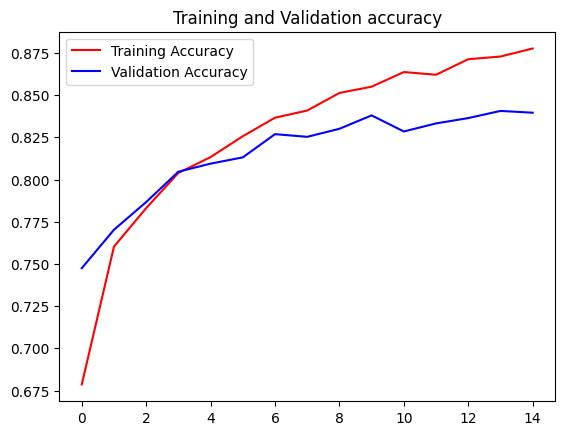

<Figure size 640x480 with 0 Axes>

In [23]:

# Plot training and val curves

acc = history.history['accuracy']
val_acc = history.history ['val_accuracy']
loss = history.history ['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label = "Training Accuracy")
plt.plot(epochs, val_acc, 'b', label = "Validation Accuracy")
plt.title('Training and Validation accuracy')
plt.legend(loc = 0)
plt.figure()

plt.show()

In [1]:
# Function to display test images

def display_images(images, predictions, true_labels, class_names, title, num_examples=6, num_cols = 2):
    num_rows = int(np.ceil(num_examples / num_cols))
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(20, 5 * num_rows))
    fig.suptitle(title)
    plt.subplots_adjust(hspace=0.5) 
    
    # Flatten the axes array for easier iteration
    axes = axes.flatten()
    
    for i in range(num_examples):
        axes[i].imshow(images[i])
        axes[i].set_title(f"True: {class_names[true_labels[i]]}\nPredicted: {class_names[predictions[i]]}")
        if true_labels[i] != predictions[i]:
            axes[i].set_title(axes[i].get_title(), color='red')
        axes[i].axis('off')
    
    plt.show()

In [ ]:
# Extract test images and labels
num_examples = 20
test_images = []
test_labels = []

for image, label in ds_test.unbatch().take(num_examples):
    test_images.append(image.numpy())
    test_labels.append(label.numpy())


In [ ]:
# Make predictions on test set
probabilities = model.predict(ds_test, batch_size=32)
predicted_labels = np.argmax(probabilities, axis=1)

# Display predictions
display_images(test_images, predicted_labels, test_labels, class_names, "True and Predicted classes", num_examples=num_examples)